## K-means clustering

Følgende kodeblok er sammensat ud fra "07-ImageSegmentation.ipynb"

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13700\1314238646.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image_raw = imread('kitten.jpg')


(400, 400, 3)


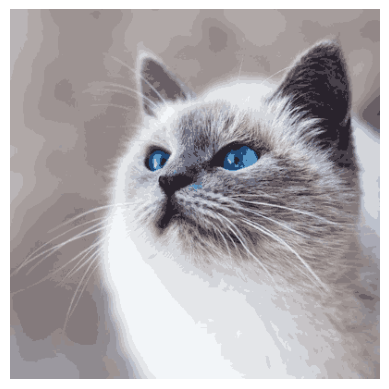

In [259]:
from imageio import imread
import numpy as np
from skimage.color import rgb2lab, lab2rgb
from skimage.transform import rescale
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt


image_raw = imread('kitten.jpg')
image_width = 400
image = rescale(image_raw, image_width/image_raw.shape[0], mode='reflect', channel_axis=2, anti_aliasing=True)
shape = image.shape

X = rgb2lab(image).reshape(-1, 3)

def cluster_assignments(X, Y):
    return np.argmin(euclidean_distances(X,Y), axis=1)

K = 20
centers = np.array([X.mean(0) + (np.random.randn(3)/10) for _ in range(K)])
y_kmeans = cluster_assignments(X, centers)

# repeat estimation a number of times (could do something smarter, like comparing if clusters change)
for i in range(30):
    # assign each point to the closest center
    y_kmeans = cluster_assignments(X, centers)

    # move the centers to the mean of their assigned points (if any)
    for i, c in enumerate(centers):
        points = X[y_kmeans == i]
        if len(points):
            centers[i] = points.mean(0)

print(shape)
plt.figure()
plt.imshow(lab2rgb(centers[y_kmeans,:].reshape(shape[0], shape[1], 3)))
plt.axis('off');

## Dithering

In [190]:
from math import sqrt

Funktionen "closest_centroid" beregner den euklidiske afstand mellem 2 farver.

In [191]:
# Funktion til at beregne afstanden mellem to RGB-farver
def find_closest_centroid_color(farve1, farve2):
    afstand = []

    for i in range(len(farve2)):
        eq = []
        #afstand.append( sqrt((farve1[0] - farve2[i][0])**2 + (farve1[1] - farve2[i][1])**2 + (farve1[2] - farve2[i][2])**2) )
        for j in range(3):
            eq.append( (farve1[j] - farve2[i][j])**2 )
            
        #print("eq: ", eq)
        afstand.append( sqrt( sum(eq) )  )
        
        #print("Afstand: ", afstand)
    
    result = afstand.index( min(afstand) )

    return result

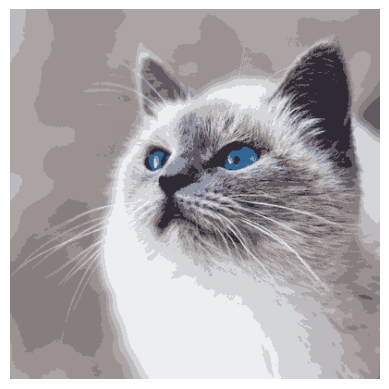

In [192]:
clustered_image = lab2rgb(centers[y_kmeans,:].reshape(shape[0], shape[1], 3))

#print(clustered_image)
plt.figure()
plt.imshow(clustered_image)
plt.axis('off');


# Centroide farver 
#lab2rgb henter rgb farven i punktet for centroiden givet i "centers".
#(standardizeret i "centers", hvorfor multipliceres med 255 = RGB)
palette = lab2rgb(centers)*255



#print(img)
#print(img[0][0])
#print(closest_centroid(img[0][0], palette))
#print(palette)


## Dithering v1.0

Implementation of Floyd-Steinberg dithering

Grayscale image:

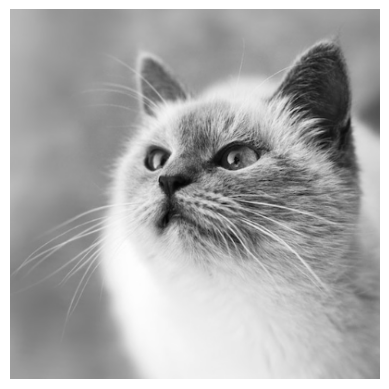

In [272]:
from PIL import Image

def grayscale(image):
    pil_img = Image.fromarray(np.uint8(image))
    gray_img = pil_img.convert('L')
    gray_np = np.array(gray_img)
    grayscale_img = np.stack((gray_np, gray_np, gray_np), axis=-1)
    return grayscale_img



'''#pil_img = Image.fromarray(np.uint8(image*255))
pil_img = Image.fromarray(np.uint8(image_raw))

gray_img = pil_img.convert('L')

#print("Min pixel value:", np.min(gray_img))
#print("Max pixel value:", np.max(gray_img))
#gray_img.show()

gray_np = np.array(gray_img)

# Create an RGB representation of the grayscale image
grayscale_img = np.stack((gray_np, gray_np, gray_np), axis=-1)'''

plt.figure()
plt.imshow(grayscale(image*255))
plt.axis('off');

In [238]:
'''plt.figure()
plt.imshow(image)
plt.axis('off');'''

"plt.figure()\nplt.imshow(image)\nplt.axis('off');"

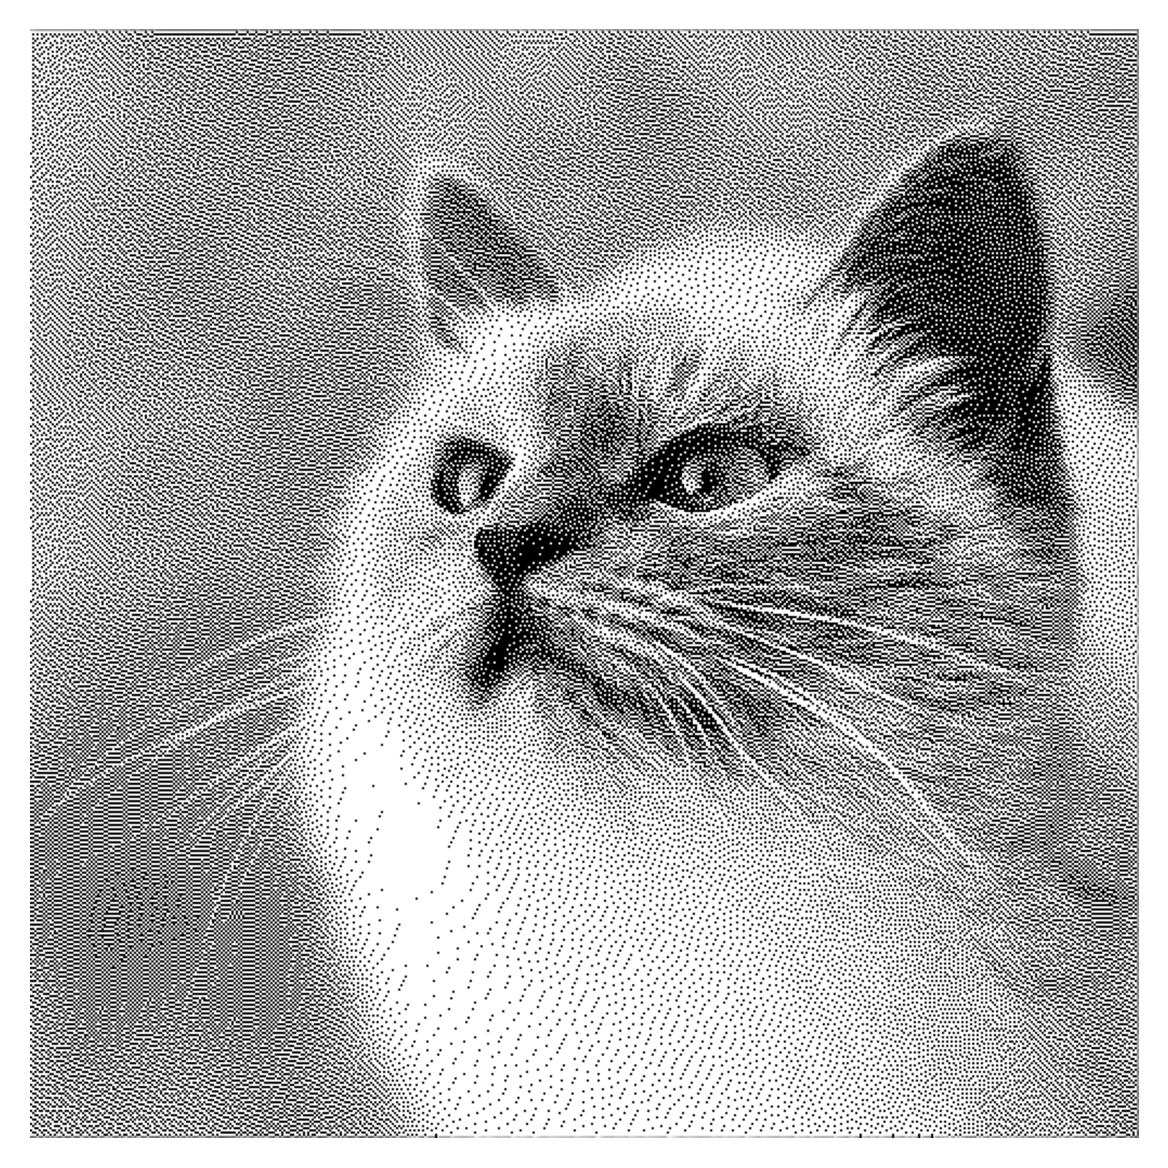

In [317]:
#import numba

def find_closest_palette_color(oldpixel):
    factor = 1
    newRGB = np.round(factor * oldpixel / 255) * 255/factor
    return newRGB.astype(np.uint8)


#@numba.jit("f4[:,:,:](f4[:,:,:])", nopython=True, nogil=True)

#img = clustered_image*255                   # k-means clustered image  # Multiplied by 255 for RGB
img = grayscale(image_raw).astype(np.float64)     # grayscale original image
#img = image_raw.astype(np.float64)                             # original image


height, width = img.shape[:2]

for y in range(0, width-1):
    for x in range(1, height-1):
        oldpixel = np.copy(img[x, y])
        newpixel = find_closest_palette_color(oldpixel)
        img[x, y] = newpixel
        quant_err = oldpixel - newpixel


        img[x + 1, y    ] += quant_err * 7/16
        img[x - 1, y + 1] += quant_err * 3/16
        img[x    , y + 1] += quant_err * 5/16
        img[x + 1, y + 1] += quant_err * 1/16


plt.figure(dpi=300)
plt.imshow(img.astype(np.uint8)/255)
plt.axis('off');

# Save the displayed image
#plt.savefig('C:/Users/Lenovo/Downloads/nicokitty.png')
#print(img.astype(np.uint8))

Image specs:

In [196]:
print("Height: ", len(img))
print("Width:", len(img[0]))
height, width = img.shape[:2]
print(height, width)

Height:  400
Width: 400
400 400


Just a test for finding the centroid colour in "palette" that is closest to a given colour.

In [197]:
print(palette)
find_closest_centroid_color(clustered_image[0][0], palette)

[[134.50841888 125.37603782 127.9647312 ]
 [ 49.15860374 102.09151509 149.96926969]
 [ 48.78519201  42.78724115  52.24167162]
 [211.69399645 213.25030034 217.94797701]
 [188.43018778 186.29138065 191.12844575]
 [171.91282622 164.05217212 163.96145846]
 [236.74645402 238.98185881 241.9245077 ]
 [155.1014484  145.98512066 145.88974817]
 [ 97.74855669  90.00966571  98.20955455]
 [145.70561629 150.05472951 166.19211735]]


2